# PROJET 6 : Partie 1- Exploration et préparation de la pipeline


## Introduction au Projet

Stack Overflow est un site célèbre de question-réponses liées au développement informatique. Pour poser une question sur ce site, il faut entrer plusieurs tags de manière à retrouver facilement la question par la suite. Pour les utilisateurs expérimentés cela ne pose pas de problème, mais pour les nouveaux utilisateurs, il serait judicieux de suggérer quelques tags relatifs à la question posée.

Amateur de Stack Overflow, qui vous a souvent sauvé la mise, vous décidez d'aider la communauté en retour. Pour cela, vous développez un système de suggestion de tag pour le site. Celui-ci prendra la forme d’un algorithme de machine learning qui assigne automatiquement plusieurs tags pertinents à une question.

Les données
Stack Overflow propose un outil d’export de données : "stackexchange explorer", qui recense un grand nombre de données authentiques de la plateforme d’entraide. 

### Contraintes

<p>Mettre en &oelig;uvre une approche non supervis&eacute;e.</p>
<p>Utiliser une approche supervis&eacute;e ou non pour extraire des tags &agrave; partir des r&eacute;sultats pr&eacute;c&eacute;dents.</p>
<p>Comparer ses r&eacute;sultats &agrave; une approche purement supervis&eacute;e, apr&egrave;s avoir appliqu&eacute; des m&eacute;thodes d&rsquo;extraction de features sp&eacute;cifiques des donn&eacute;es textuelles.</p>
<p>Mettre en place une m&eacute;thode d&rsquo;&eacute;valuation propre, avec une s&eacute;paration du jeu de donn&eacute;es pour l&rsquo;&eacute;valuation.</p>
<p>Pour suivre les modifications du code final &agrave; d&eacute;ployer, utiliser un logiciel de gestion de versions, par exemple git.</p>

# Prétraitement des données

### Import des librairies

In [1]:
import pandas as pd
import os
import numpy as np
import urllib
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings("ignore")
import re
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import mglearn
from mglearn import tools
from sklearn.externals import joblib
# Plotting tools
import matplotlib.pyplot as plt
import glob

%matplotlib inline

[nltk_data] Downloading package wordnet to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Windows
[nltk_data]     10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Chargement des données

In [48]:
current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
import glob
allFiles = glob.glob(parent_path + "\data\Query*.csv")
list_ = []
for file in allFiles:
    print("Chargement du fichier: {}".format(file))
    try:
        df = pd.read_csv(file,index_col=None, header=0)
        list_.append(df)
    except FileNotFoundError:
        print("Merci de vérifier la présence de {} dans le répertoire 'data'".format(file))
df_raw = pd.concat(list_, axis = 0, ignore_index = True)
print("Concaténation effectuée et dataframe prête") 

Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults1.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults3.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults4.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults5.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults6.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults7.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults8.csv
Chargement du fichier: C:\Users\Windows 10\Desktop\Formations\OpenClassRooms\Projet 6\data\QueryResults9.csv
Concaténation effectuée et dataframe prête


In [49]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147665 entries, 0 to 147664
Data columns (total 22 columns):
Id                       147665 non-null int64
PostTypeId               147665 non-null int64
AcceptedAnswerId         110015 non-null float64
ParentId                 0 non-null float64
CreationDate             147665 non-null object
DeletionDate             0 non-null float64
Score                    147665 non-null int64
ViewCount                147665 non-null int64
Body                     147665 non-null object
OwnerUserId              129994 non-null float64
OwnerDisplayName         89232 non-null object
LastEditorUserId         93539 non-null float64
LastEditorDisplayName    44662 non-null object
LastEditDate             95657 non-null object
LastActivityDate         147665 non-null object
Title                    147665 non-null object
Tags                     147665 non-null object
AnswerCount              147665 non-null int64
CommentCount             147665 non-nul

In [50]:
# Chargement d'un échantillon aléatoire
df_raw=df_raw.sample(50000, random_state=0)

In [51]:
df_raw.describe(include = "all")

,Id,PostTypeId,AcceptedAnswerId,ParentId,CreationDate,DeletionDate,Score,ViewCount,Body,OwnerUserId,...,LastEditorDisplayName,LastEditDate,LastActivityDate,Title,Tags,AnswerCount,CommentCount,FavoriteCount,ClosedDate,CommunityOwnedDate
count,50000.000000,50000.0,3.719700e+04,0.0,50000,0.0,50000.000000,5.000000e+04,50000,4.404500e+04,...,15172,32440,50000,50000,50000,50000.000000,50000.000000,29342.00000,2972,973
unique,NaN,NaN,NaN,NaN,49913,NaN,NaN,NaN,49998,NaN,...,5085,31229,49948,49994,37212,NaN,NaN,NaN,2972,973
top,NaN,NaN,NaN,NaN,2009-05-15 20:59:05,NaN,NaN,NaN,<p>Anyone have any idea? And any open source s...,NaN,...,Rich B,2017-05-23 12:26:44,2014-08-30 21:07:01,select random file from directory,<c#>,NaN,NaN,NaN,2012-07-13 09:19:47,2010-02-04 22:53:25
freq,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,2,NaN,...,334,37,4,2,280,NaN,NaN,NaN,1,1
mean,593015.878680,1.0,7.829168e+05,NaN,NaN,NaN,19.188760,1.773688e+04,NaN,7.454473e+04,...,NaN,NaN,NaN,NaN,NaN,4.292600,0.843840,12.38525,NaN,NaN
std,279991.005059,0.0,1.859575e+06,NaN,NaN,NaN,111.389633,8.253575e+04,NaN,2.486135e+05,...,NaN,NaN,NaN,NaN,NaN,5.100367,1.657621,83.76470,NaN,NaN
min,6.000000,1.0,2.600000e+01,NaN,NaN,NaN,-7.000000,2.000000e+01,NaN,1.000000e+00,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00000,NaN,NaN
25%,427688.750000,1.0,4.372950e+05,NaN,NaN,NaN,1.000000,8.340000e+02,NaN,1.138400e+04,...,NaN,NaN,NaN,NaN,NaN,2.000000,0.000000,1.00000,NaN,NaN
50%,635717.500000,1.0,6.499640e+05,NaN,NaN,NaN,3.000000,2.472000e+03,NaN,3.862900e+04,...,NaN,NaN,NaN,NaN,NaN,3.000000,0.000000,2.00000,NaN,NaN
75%,826772.250000,1.0,8.504690e+05,NaN,NaN,NaN,8.000000,8.540250e+03,NaN,6.886900e+04,...,NaN,NaN,NaN,NaN,NaN,5.000000,1.000000,6.00000,NaN,NaN


On ne conserve que ce qui nous intéresse, à savoir les features 'Title', 'Tags','Body'

In [52]:
df_raw = df_raw.loc[:, ['Title', 'Tags','Body']]

In [53]:
#Infos sur la dataframe
df_info=pd.DataFrame(df_raw.dtypes).T.rename(index={0:'column type'})
df_info=df_info.append(pd.DataFrame(df_raw.isnull().sum()).T.rename(index={0:'null values (nb)'}))
df_info=df_info.append(pd.DataFrame(df_raw.isnull().sum()/df_raw.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(df_info)

,Title,Tags,Body
column type,object,object,object
null values (nb),0,0,0
null values (%),0,0,0


In [54]:
df_raw.head()

,Title,Tags,Body
13086,PowerBuilder database connection pool? How-to,<database><connection-pooling><powerbuilder>,<p>How to make database connection pool in Pow...
94879,List all DLL's implementing a specific interfa...,<c#><plugins><gac>,<p>Aloha</p>\n\n<p>Given a plug-in architectur...
95106,Do all developers consider monitor quality (co...,<colors><development-environment>,<p>I especially hear it from those advocates o...
63463,Only OnConnection fires in Visual Studio add-in,<visual-studio><visual-studio-2008>,"<p>I'm busy with a small, simple add-in, but t..."
23730,How to cache images in memory on the web serve...,<asp.net><asp.net-mvc><caching>,<p>I am working on a web application with many...


### Traitement des TAGS Manquants

In [55]:
# Retrait des lignes sans Tags
df_raw = df_raw.dropna(subset=['Tags'])
print('Dataframe dimensions:', df_raw.shape)

Dataframe dimensions: (50000, 3)


### Traitement des doublons

In [56]:
#Suppression des doublons
print('Entrées en double: {}'.format(df_raw.duplicated(subset=["Body"]).sum()))
df_raw.drop_duplicates(subset=["Body"],inplace = True)
print('Dataframe dimensions:', df_raw.shape)

Entrées en double: 2
Dataframe dimensions: (49998, 3)


## Fonctions liées au pré-traitement des données

In [57]:
def get_stop_words(stop_file_path):
    """Chargement du fichier de stopwords """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 


In [58]:
def count_tags(data):
    """ Fonction qui permet de compter les différents tags, de les classer et de donner le pourcentage
    """
    count_df = pd.Series(data.loc[:, question_tags_featured].squeeze().values.reshape(-1)).value_counts()
    ct_df = pd.DataFrame({'Tag': count_df.index,
                                  'Count': count_df.values,
                                  'Pourcentage (%)': (100 * (count_df / count_df.sum())).values})
    return ct_df

In [59]:
def get_wordnet_pos(word):
    """Map POS tag"""
    # On chosit la première lettre
    tag = nltk.pos_tag([word])[0][1][0].upper()
    # Creation d'un dictionnaire
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    # Return relevant tag otherwise Noun
    return tag_dict.get(tag, wordnet.NOUN)

In [60]:
def text_processing(raw_text):
    """
    Fonction qui permet de convertir un texte brut en une chaîne de caractères
    En entrée nous avons une chaîne brute et en sortie une seule chaîne.
    """
    # 1. Nettoyer HTML
    striped_text = BeautifulSoup(raw_text, "lxml").get_text() 

    # 2. Nettoyer ce qui n'est pas une lettre
    letters_numbers_only = re.sub("[^a-zA-Z#+]", " ", striped_text) 

    # 3. On change en minuscule les caractères
    words = letters_numbers_only.lower()
    
    return(' '.join(words.split()))


In [61]:
def text_processing_stop_words(raw_text):
    """
    Fonction qui permet de convertir un texte brut en une chaîne de caractères
    En entrée nous avons une chaîne brute et en sortie une seule chaîne. Nous utilisons les stopwords.
    """
    # 1. Nettoyer HTML
    striped_text = BeautifulSoup(raw_text, "lxml").get_text() 

    # 2. Retirer ce qui n'est pas une lettre alphabétique      
    letters_numbers_only = re.sub("[^a-zA-Z#+]", " ", striped_text) 

    # 3. Conversion en minuscule et découpage
    words = letters_numbers_only.lower().split()
    
    # 4. Chargement des stopwords
    stops = get_stop_words(parent_path + "\\resources\\stopwords.txt")

    # 5. Retrait des stopwords
    meaningful_words = [w for w in words if not w in stops]  
    
    return meaningful_words

In [62]:
def text_processing_advanced(raw_body):
    """
    Fonction avancée qui permet de convertir un texte brut en une chaîne de caractères
    En entrée nous avons une chaîne brute et en sortie une seule chaîne. Nous utilisons les stopwords et lemmatisation.
    """
    # 1. Nettoyer HTML
    body_text = BeautifulSoup(raw_body, "lxml").get_text() 

    # 2. Retirer ce qui n'est pas une lettre alphabétique       
    letters_numbers_only = re.sub("[^a-zA-Z#+]", " ", body_text) 

    # 3. Conversion en minuscule et découpage
    words = letters_numbers_only.lower().split()                             

    # 4. Chargement des stopwords
#     stops = set(stopwords.words("english"))
    stops = get_stop_words(parent_path + "\\resources\\stopwords.txt")

    # 5. Retrait des stop words
    meaningful_words = [w for w in words if not w in stops]   

    # 6. Lemmatisation des mots
    lemmatizer = WordNetLemmatizer()
    lemmatize_meaningful_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in meaningful_words]
    
    return (" ".join( lemmatize_meaningful_words)) 

In [63]:
def data_preprocessing(data):
    """
    Fonction qui permet de traiter en entrée une dataframe avec nos documents texte et d'obtenir en sortie
    un vecteur de données après nettoyage des données au préalable.
    """  
    # Concaténation
    data["Body_Title"] = data["Title"] + " " + data["Body"]
    
    #Chargement des stop words
    stops = get_stop_words(parent_path + "\\resources\\stopwords.txt")

    #On concatène les colonnes "Body" et "Title" qui contiennent toutes les deux des informations importantes.
    data["Body_Title"] = data["Title"] + " " + data["Body"]

    # Traitement sur Body_Title
    print("Nettoyage Body_Title")
    bodytitle_words_clean = pd.DataFrame(columns=['body_title_words'])
    
    # On effectue un text_processing à "Body_Title"
    bodytitle_words_clean['body_title_words'] = data.Body_Title.apply(text_processing)

    # Implémentation du Vectorizer pour créer nos bag of words
    vectorizer = TfidfVectorizer(min_df=20,analyzer="word", tokenizer=None, preprocessor=None, stop_words=stops, binary=False,max_features=10000) 

    print("Vectorisation de Body_Title en bag of words en cours")
    bodytitle_words_features = vectorizer.fit_transform(bodytitle_words_clean.body_title_words)
    
    print("Vectorisation de Body_Title effectuée")
    print("Taille suite à vectorisation de Body_Title {}".format(bodytitle_words_features.shape))
    print("Fin du data preprocessing")
    
    return bodytitle_words_features, vectorizer

In [64]:
def data_preprocessing_test(data,vectorizer):
    """
    Fonction qui permet de traiter en entrée une dataframe avec nos documents texte et d'obtenir en sortie
    un vecteur de données après nettoyage des données au préalable.
    """  
    # Concaténation des colonnes Body et Title pour n'en fomer qu'une
    data["Body_Title"] = data["Title"] + " " + data["Body"]
    
    # Chargement des stop words
    stops = get_stop_words(parent_path + "\\resources\\stopwords.txt")

    #On concatène les colonnes "Body" et "Title" qui contiennent toutes les deux des informations importantes.
    data["Body_Title"] = data["Title"] + " " + data["Body"]

    # Traitement sur Body_Title
    print("Nettoyage Body_Title")
    bodytitle_words_clean = pd.DataFrame(columns=['body_title_words'])
    
    # On effectue un text_processing à "Body_Title"
    bodytitle_words_clean['body_title_words'] = data.Body_Title.apply(text_processing)

   
    print("Vectorisation de Body_Title en bag of words en cours")
    bodytitle_words_features_test = vectorizer.transform(bodytitle_words_clean.body_title_words)
    print("Vectorisation de Body_Title effectuée")
    print("Taille suite à vectorisation de Body_Title {}".format(bodytitle_words_features_test.shape))
    print("Fin du data preprocessing")
    return bodytitle_words_features_test

In [65]:
def ml_create_target_df(selected_tags,data_set):
    """
        Création de notre matrice cible à partir de notre jeu de tags qui contient
        les tags propres à chaque question posée
    """
    print(" La dataframe cible contient {} tags...Traitement en cours".format(selected_tags.shape[0]))
    # Création de numpy array
    temp_array = np.zeros((data_set.shape[0], selected_tags.shape[0]))
    # Boucle sur tags
    for i, tag in zip(range(temp_array.shape[1]), selected_tags.values):
        temp_array[:, i] = np.sum(data_set.loc[:, question_tags_featured] == tag, axis=1)

    # On limite notre tableau aux valeurs 0 ou 1
    temp_array[temp_array > 1] = 1
    
    # Conversion en pandas dataframe
    ml_target_df = pd.DataFrame(temp_array, columns=selected_tags, dtype='int64')
    
#     # On supprime les lignes qui ne contienent que des zéros
    print("Traitement terminé")
    return ml_target_df

# Exploration des données, analyses et tests

## Exemple de Nettoyage de texte

Regardons de plus près ce qui se passe lorsque l'on applique le nettoyage de texte sur un échantillon

In [66]:
N_test=250
print("*********** Texte brut")
display(df_raw["Body"].iloc[N_test])
print("*********** Sans lemmatisation")
display(text_processing(df_raw["Body"].iloc[N_test]))
print("************ Avec lemmatisation")
display(text_processing_advanced(df_raw["Body"].iloc[N_test]))

*********** Texte brut


'<p>I trid to use an upload plugin for jQuery.\n<a href="http://valums.com/ajax-upload/" rel="nofollow noreferrer">http://valums.com/ajax-upload/</a></p>\n\n<p>When I set the returning respond type to json, firefox will popup a dialog asking how I like to handle the returning json object.</p>\n\n<p>People have asked the same question at the upload script\'s author\'s page but no answer so far. Hopefully javascript guys here can figure out how we can handle this.</p>\n\n<p>Thanks.</p>\n\n<pre><code>&lt;script type= "text/javascript"&gt;\n      /*&lt;![CDATA[*/\n        $(document).ready(function(){\n\n            /* example 1 */\n            var button = $(\'#button1\'), interval;\n            new AjaxUpload(button, {\n                //action: \'upload-test.php\', // I disabled uploads in this example for security reasons\n                action: \'/posts/upload_images/\', \n                name: \'myfile\',\n                responseType: \'json\',\n                onSubmit : function(

*********** Sans lemmatisation


'i trid to use an upload plugin for jquery http valums com ajax upload when i set the returning respond type to json firefox will popup a dialog asking how i like to handle the returning json object people have asked the same question at the upload script s author s page but no answer so far hopefully javascript guys here can figure out how we can handle this thanks script type text javascript cdata document ready function example var button #button interval new ajaxupload button action upload test php i disabled uploads in this example for security reasons action posts upload images name myfile responsetype json onsubmit function file ext change button text when user selects file button text uploading if you want to allow uploading only file at time you can disable upload button this disable uploding uploading uploading interval window setinterval function var text button text if text length button text text + else button text uploading oncomplete function file response var json respo

************ Avec lemmatisation


'trid upload plugin jquery valums com ajax upload return json firefox popup dialog ask return json ask upload javascript guy javascript cdata var #button ajaxupload upload php uploads reason post upload image myfile responsetype json onsubmit ext selects upload upload disable upload disable uploding upload upload window setinterval var + upload oncomplete var json alert json upload window clearinterval upload appendto #example json appendto #example'

## Visualisation du nombre de mots sur features Body_Title 
Cherchons à visualiser le mots les plus fréquents sans traitement TF-IDF et avec traitement TF-IDFµ.

### Sans traitement TF_IDF
 On concatène les colonnes "Body" et "Title" qui contiennent toutes les deux des informations importantes.

In [67]:
df_raw["Body_Title"] = df_raw["Title"] + " " + df_raw["Body"]

In [68]:
# Nettoyage en utilisant les stop words
bodytitle_clean_serie = df_raw.loc[:, 'Body_Title'].apply(text_processing_stop_words)
Body_Title_clean_df = pd.DataFrame(bodytitle_clean_serie)

one_bodytitle_list = [item for sublist in Body_Title_clean_df.Body_Title.ravel() for item in sublist]
bodytitle_words_clean = pd.Series(one_bodytitle_list)
bodytitlecounts = bodytitle_words_clean.value_counts()

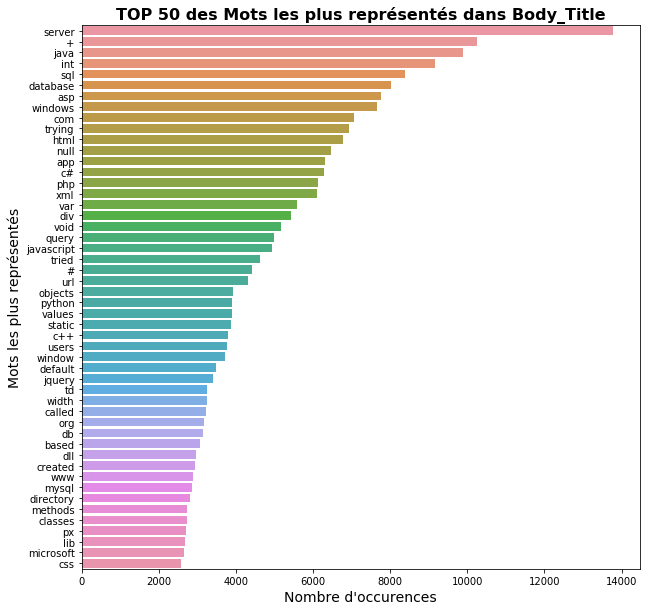

In [69]:
# Affichage
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(y=bodytitlecounts[:50].index.values, x=bodytitlecounts[:50].values, orient='h')
ax.set_ylabel("Mots les plus représentés", fontsize=14)
ax.set_xlabel("Nombre d'occurences", fontsize=14)
ax.set_title("TOP 50 des Mots les plus représentés dans Body_Title", fontsize=16,weight="bold");


### Avec traitement TF_IDF

In [70]:
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [71]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [72]:
def top_mean_feats(Xtr, features, min_tfidf=0, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified. '''
    D = Xtr.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [73]:
# Traitement sur Body_Title
print("Nettoyage Body_Title")
print("Chargement des stop words")
stops = get_stop_words(parent_path + "\\resources\\stopwords.txt")
bodytitle_words_clean = pd.DataFrame(columns=['body_title_words'])

# On effectue un text_processing à "Body_Title"
bodytitle_words_clean['body_title_words'] = df_raw.Body_Title.apply(text_processing)

# Implémentation du Vectorizer pour créer nos bag of words
vectorizer = TfidfVectorizer(min_df=20,analyzer="word", tokenizer=None, preprocessor=None, stop_words=stops, binary=False,max_features=10000) 

print("Vectorisation de Body_Title avec transformation TF_IDF")
bodytitle_words = vectorizer.fit_transform(bodytitle_words_clean.body_title_words)


Nettoyage Body_Title
Chargement des stop words
Vectorisation de Body_Title avec transformation TF_IDF


In [74]:
# On extrait le top 50 des mots du TF IDF
top_tfidf = top_mean_feats(bodytitle_words, vectorizer.get_feature_names(),top_n=50)

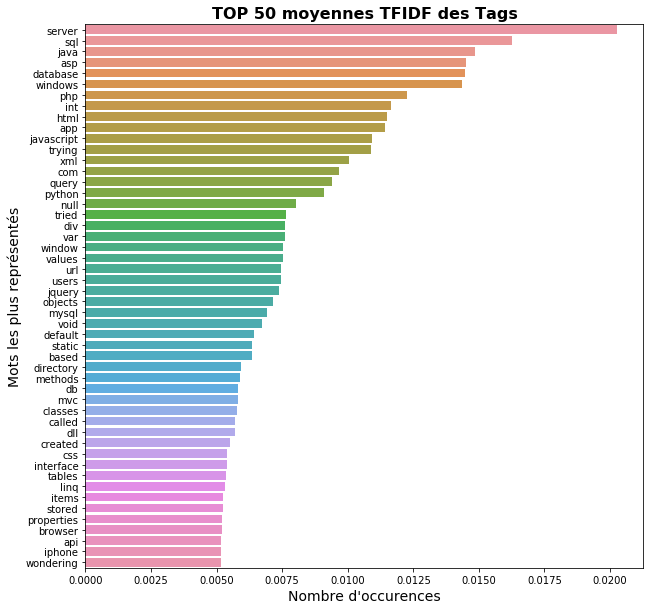

In [75]:
# On représente le diagramme bâton du top 50
fig, ax = plt.subplots(figsize=(10, 10))
top_tfidf = top_mean_feats(bodytitle_words, vectorizer.get_feature_names(),top_n=50)
sns.barplot(y=top_tfidf["feature"], x=top_tfidf["tfidf"], orient='h')
ax.set_title("TOP 50 moyennes TFIDF des Tags", fontsize=16, weight="bold");
ax.set_ylabel("Mots les plus représentés", fontsize=14)
ax.set_xlabel("Nombre d'occurences", fontsize=14);

In [76]:
# Taille de notre matrice 
bodytitle_words.shape

(49998, 5218)

### Exemple de traitement sur TF_IDF un exemple de texte
Regardons maintenant un traitement TF-IDF sur un texte d'exemple et regardons de plus près les scores calculés.

In [77]:
row_example=200
print("\n=====Body_Title=====")
display(df_raw["Body_Title"].iloc[row_example])
print("\n=====Body_Title Nettoyé=====")
display(text_processing(df_raw["Body_Title"].iloc[row_example]))
print("\n=====Top 15 Mots TF-IDF=====")
top_feats_in_doc(bodytitle_words,features=vectorizer.get_feature_names(), row_id=row_example, top_n=15)


=====Body_Title=====


'Making Development Better with Static Analysis <p>I find, when I\'m reviewing VBA code, that most of the bugs are easily classified errors, such as typos, not setting things to <code>Nothing</code>, not closing DB connections, etc.</p>\n\n<p>I know that using "Option Explicit" can solve some of these, but I\'d rather use something more powerful.</p>\n\n<p>Are there any static analysis tools for VBA?</p>\n'


=====Body_Title Nettoyé=====


'making development better with static analysis i find when i m reviewing vba code that most of the bugs are easily classified errors such as typos not setting things to nothing not closing db connections etc i know that using option explicit can solve some of these but i d rather use something more powerful are there any static analysis tools for vba'


=====Top 15 Mots TF-IDF=====


,feature,tfidf
0,vba,0.576274
1,static,0.375467
2,reviewing,0.363104
3,bugs,0.281752
4,closing,0.278213
5,connections,0.267103
6,tools,0.208878
7,making,0.207475
8,errors,0.206735
9,db,0.193756


## Traitement des TAGS

Nous cherchons à récupérer les Tags présents pour l'ensemble des questions afin de pouvoir les classer par fréquence d'apparition.

### Fréquence des Tags

In [78]:
# feature engineering. On crée 5 nouvelles features pour les tags
question_tags_featured = ['Tag_1', 'Tag_2', 'Tag_3', 'Tag_4', 'Tag_5']

In [79]:
# On retire les Tags chevrons
df_raw['Tags'] = df_raw.Tags.apply(lambda x: x.strip('<').strip('>').replace('>', '').replace('<', '/'))

# On compte les Tags présents
df_raw['number_of_Tags'] = df_raw.Tags.apply(lambda x: len(x.split('/')))

# découpage des tags
tags_lists = df_raw.Tags.apply(lambda x: x.split('/'))

In [80]:
# Initialisation de la nouvelle liste de Tags
filled_tags_list = []
# boucle sur la liste de tags
for inner_list in tags_lists:
    # taille de la liste
    length = len(inner_list)
    
    while length < 5:
        inner_list.append(np.nan)
        length = len(inner_list)
    filled_tags_list.append(inner_list)

In [81]:
# Création de dataframe
tags_df = pd.DataFrame(filled_tags_list)

# Suppression de colonne vide
tags_df=tags_df[tags_df.columns[:-1]]
tags_df.index = df_raw.index
tags_df.columns = question_tags_featured

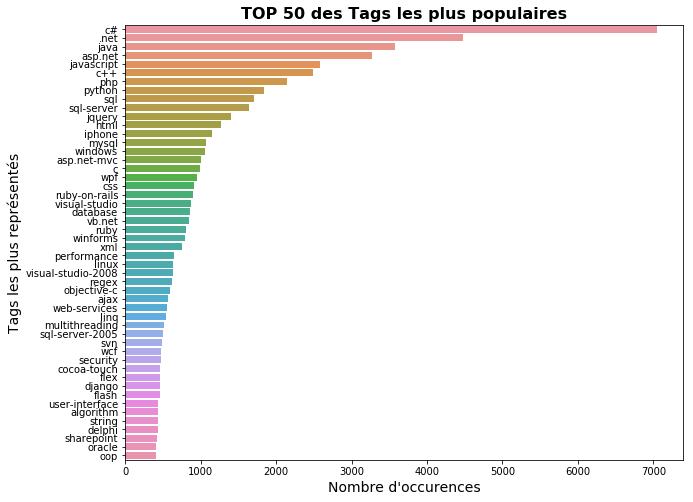

In [82]:
# concatenation des tags avec la dataframe de départ
df_raw = pd.concat((df_raw, tags_df), axis=1)
count_tags_df=count_tags(df_raw)
fig, ax = plt.subplots(figsize=(10, 8))
plot = sns.barplot(y='Tag', x='Count', data=count_tags_df[:50], orient='h')
ax.set_title("TOP 50 des Tags les plus populaires", fontsize=16, weight="bold")
ax.set_ylabel("Tags les plus représentés", fontsize=14)
ax.set_xlabel("Nombre d'occurences", fontsize=14);


In [83]:
#TOP 10 TAGS
count_tags_df.head(10)

,Tag,Count,Pourcentage (%)
0,c#,7043,4.868153
1,.net,4482,3.097978
2,java,3576,2.471747
3,asp.net,3270,2.260238
4,javascript,2582,1.784690
5,c++,2487,1.719025
6,php,2143,1.481251
7,python,1833,1.266978
8,sql,1702,1.176430
9,sql-server,1638,1.132193


In [84]:
# On compte le nombre tags différents
temp_list = [x.split('/') for x in df_raw.Tags.values.tolist()]
tags_list = [y for x in temp_list for y in x]
unique_tags = list(set(tags_list))
# Suppression des nan
for value in unique_tags:
    try:
        if np.isnan(value):
            unique_tags.remove(value)
    except:
        pass
print("Nous possédons {} Tag différents".format(len(unique_tags)))

Nous possédons 9098 Tag différents


Regardons maintenant la répartition des nombres de tags attribués à chaque question.

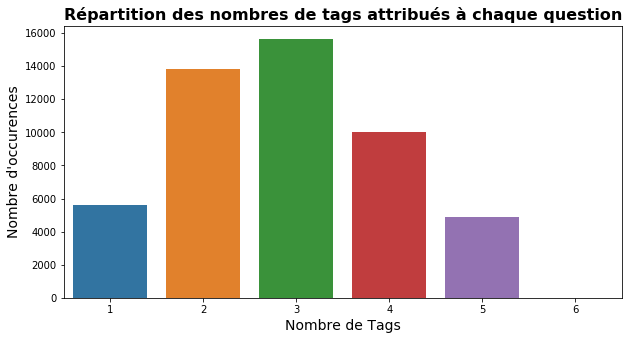

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Répartition des nombres de tags attribués à chaque question", fontsize=16, weight="bold");
sns.countplot(df_raw['number_of_Tags'])
ax.set_ylabel("Nombre d'occurences", fontsize=14)
ax.set_xlabel("Nombre de Tags", fontsize=14);


### Quelques variables à conserver...

In [86]:
# Récupération du nombre de tags et du tag le plus populaire
most_popular_tag = count_tags_df.Tag[0]

# On récupère tous les tags pour une utilisation ultérieure
unique_tags_serie = pd.Series(unique_tags).apply(lambda x: [x])

# Préparation de la Pipeline pour l'entrainement des données

### Réduction de dimension par séléction du ratio de tags à conserver

In [87]:
# On définit un pourcentage seuil
threshold_percentage = 50
threshold_count = 0

# Création d'une dataframe
df_work = df_raw
count_tags_df = count_tags(df_work)
top_tags = count_tags_df[count_tags_df["Pourcentage (%)"].cumsum(axis=0)<threshold_percentage]
list_top_tags = top_tags.Tag.tolist()

# On sélectionne les données qui possèdent plus que le seuil imposé
selected_tags = top_tags[top_tags["Count"] >= threshold_count]["Tag"]

print("Sélection de {} Tags dans notre jeu d'entrainement".format(selected_tags.shape[0]))

Sélection de 99 Tags dans notre jeu d'entrainement


In [88]:

# Retrait les tags pour chaque question qui ne sont pas parmi le top tags retenus.
mask = df_work[question_tags_featured].isin(list_top_tags)
df_work[question_tags_featured]=df_work[mask][question_tags_featured]
df_work = df_work[(df_work.T != 0).any()]
df_work = df_work.dropna(thresh=len(df_work.columns)-4)

# On distingue nos données en jeu d'entrainement et jeu de test 
data_train, data_test = model_selection.train_test_split(df_work, test_size=0.25)
data_train["New_tags"] = data_train[question_tags_featured].apply(lambda x: '/'.join(x.dropna()),axis=1)
data_test["New_tags"] = data_test[question_tags_featured].apply(lambda x: '/'.join(x.dropna()),axis=1)

# On applique le traitement sur les données d'entrainement pour obtenir le vecteur d'entrainement
X_train, vectorizer = data_preprocessing(data_train)

# On applique le vectorizer sur les données test pour obtenir le vecteur de test
X_test = data_preprocessing_test(data_test,vectorizer)


Nettoyage Body_Title
Vectorisation de Body_Title en bag of words en cours
Vectorisation de Body_Title effectuée
Taille suite à vectorisation de Body_Title (32271, 3849)
Fin du data preprocessing
Nettoyage Body_Title
Vectorisation de Body_Title en bag of words en cours
Vectorisation de Body_Title effectuée
Taille suite à vectorisation de Body_Title (10757, 3849)
Fin du data preprocessing


Nous pouvons visualiser les tags d'origine avec les Tags transformés-filtrés après Feature Engineering

In [89]:
# Comparaison des tags
data_train[["Tags","New_tags"]].head(15)

,Tags,New_tags
36197,c#/dataset/relation,c#
53731,asp.net-mvc/routes,asp.net-mvc
59060,javascript/optimization/dom,javascript/optimization
126859,c#/.net/friendfeed,c#/.net
31264,php/regex,php/regex
41158,sharepoint/moss,sharepoint
142210,windows,windows
98165,css/firefox/printing/print-css,css/firefox
38172,asp.net/file-upload,asp.net
12592,c#/class,c#


###  Obtention des variables cibles

In [90]:
# on fait appel à la fonction ml_create_target_df pour formater nos étiquettes de tags
y_train = ml_create_target_df(selected_tags, data_train)
y_test = ml_create_target_df(selected_tags, data_test)

 La dataframe cible contient 99 tags...Traitement en cours
Traitement terminé
 La dataframe cible contient 99 tags...Traitement en cours
Traitement terminé


In [91]:
print(X_train.shape)
print(X_test.shape)

(32271, 3849)
(10757, 3849)


## Sauvegardes

Nous sauvegardons nos jeux d'entrainement et de test ainsi que différentes dataframes et données utiles pour la suite.

In [92]:
# Sauvegardes des pipelines au format .pkl
joblib.dump(X_train, parent_path + "\\pipeline\\X_train.pkl")
joblib.dump(X_test, parent_path + "\\pipeline\\X_test.pkl")
joblib.dump(data_train, parent_path + "\\pipeline\\data_train.pkl")
joblib.dump(data_test, parent_path + "\\pipeline\\data_test.pkl")
joblib.dump(y_train, parent_path + "\\pipeline\\y_train.pkl")
joblib.dump(y_test, parent_path + "\\pipeline\\y_test.pkl")

# # Sauvegardes des Dataframes et données au format .pkl
joblib.dump(vectorizer, parent_path + "\\pipeline\\vectorizer.pkl")
joblib.dump(count_tags_df, parent_path + "\\pipeline\\count_tags_df.pkl")
joblib.dump(most_popular_tag, parent_path + "\\pipeline\\most_popular_tag.pkl")
joblib.dump(unique_tags_serie, parent_path + "\\pipeline\\unique_tags_serie.pkl")
joblib.dump(unique_tags, parent_path + "\\pipeline\\unique_tags.pkl")
joblib.dump(selected_tags,parent_path + "\\pipeline\\selected_tags.pkl")
joblib.dump(list_top_tags, parent_path + "\\pipeline\\list_top_tags.pkl")

['C:\\Users\\Windows 10\\Desktop\\Formations\\OpenClassRooms\\Projet 6\\pipeline\\list_top_tags.pkl']